In [1]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [2]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'content': <memory at 0x71243c508d00>, 'last_modified': datetime.datetime(2025, 4, 21, 6, 7, 11, 972000, tzinfo=datetime.timezone.utc)}
kaggle.json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [3]:
!kaggle datasets list -s cifar


ref                                                     title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                  168517809  2020-12-26 08:37:10.143000          12259        176  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                   340613496  2018-01-27 13:42:40.967000          14775        252  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                         1007971063  2019-10-01 12:50:23.227000           2862         26  0.8235294        
valentynsichkar/cifar10-preprocessed                   

In [4]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')


cp: cannot stat 'kaggle.json': No such file or directory
 99%|████████████████████████████████████████▍| 681M/691M [00:03<00:00, 182MB/s]
100%|█████████████████████████████████████████| 691M/691M [00:03<00:00, 182MB/s]
  error:  invalid compressed data to inflate dog-breed-identification/test/157acf40281d77f6fa1e73df81dd91ba.jpg
file #904:  bad zipfile offset (lseek):  30588928
file #905:  bad zipfile offset (lseek):  30621696
file #906:  bad zipfile offset (lseek):  30662656
file #907:  bad zipfile offset (lseek):  30695424
file #908:  bad zipfile offset (lseek):  30728192
file #909:  bad zipfile offset (lseek):  30752768
file #910:  bad zipfile offset (lseek):  30769152
file #911:  bad zipfile offset (lseek):  30810112
file #912:  bad zipfile offset (lseek):  30859264
file #913:  bad zipfile offset (lseek):  30908416
file #914:  bad zipfile offset (lseek):  30932992
file #915:  bad zipfile offset (lseek):  30957568
file #916:  bad zipfile offset (lseek):  30982144
file #917:  bad zip

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [00:55<00:00, 182.60it/s]


In [6]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

from PIL import UnidentifiedImageError
class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            print(f"Cannot open image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # 嘗試下一張

        if self.transform:
            image = self.transform(image)
    
        return image, label

In [7]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])



test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

In [8]:
# 建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import collections
from collections import Counter

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 取得 training set 的原始 indices
train_indices = train_dataset.indices  # 是 dataset 中對應的索引
train_labels = [dataset.labels[i] for i in train_indices]

# 計算類別樣本數與每個 sample 權重
label_counts = Counter(train_labels)
class_sample_counts = [label_counts[i] for i in range(len(label_counts))]
sample_weights = [1.0 / class_sample_counts[label] for label in train_labels]

# 建立 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 顯示類別分布（驗證分布仍可看是否合理）
val_labels = [dataset.labels[i] for i in val_dataset.indices]
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:", Counter(val_labels))


Train label distribution: Counter({97: 109, 11: 103, 73: 95, 1: 93, 52: 93, 109: 93, 100: 91, 87: 89, 3: 87, 7: 86, 84: 85, 42: 85, 69: 85, 61: 85, 68: 84, 6: 84, 93: 84, 9: 83, 13: 82, 26: 82, 59: 80, 35: 78, 94: 77, 55: 77, 60: 76, 78: 76, 54: 75, 39: 75, 88: 75, 30: 75, 70: 74, 19: 74, 17: 74, 56: 73, 86: 73, 101: 73, 80: 73, 10: 72, 75: 72, 2: 72, 92: 71, 64: 71, 95: 71, 117: 71, 33: 69, 62: 68, 20: 68, 63: 68, 90: 68, 79: 68, 102: 68, 67: 68, 114: 68, 74: 67, 8: 67, 82: 67, 5: 66, 96: 66, 105: 65, 111: 65, 116: 65, 12: 65, 119: 65, 53: 64, 14: 64, 31: 64, 50: 64, 28: 64, 40: 64, 37: 64, 18: 63, 58: 63, 110: 63, 21: 63, 29: 63, 15: 62, 27: 62, 118: 62, 91: 62, 32: 62, 98: 62, 76: 62, 41: 61, 25: 61, 71: 60, 16: 60, 99: 60, 83: 60, 0: 60, 107: 59, 108: 59, 72: 59, 48: 59, 34: 59, 51: 58, 81: 58, 36: 58, 44: 57, 4: 57, 106: 57, 23: 57, 113: 57, 57: 57, 89: 57, 115: 57, 85: 56, 47: 56, 66: 56, 22: 56, 45: 55, 38: 55, 46: 54, 24: 54, 104: 53, 77: 53, 43: 53, 65: 52, 49: 52, 112: 51, 10

In [9]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


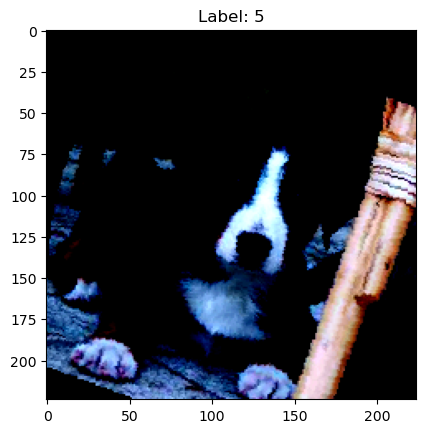

In [10]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [11]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [12]:
!pip install timm


In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 120  # Dog Breed Identification 有 120 類別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import timm

# timm 中的 xception 模型，使用預訓練權重
model = timm.create_model('xception', pretrained=True, num_classes=num_classes)


# 搬移到裝置（GPU 或 CPU）
model = model.to(device)

/opt/conda/lib/python3.9/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [14]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
num_epochs = 30
# 1. 計算 class weights（根據整體 dataset 分布）
from collections import Counter

label_counts = Counter(dataset.labels)
num_classes = 120
class_counts = [label_counts[i] for i in range(num_classes)]

# 權重：類別樣本越少，損失權重越高
weights = [1.0 / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float).to(device)
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# 定義損失函數與優化器
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)



In [15]:

for epoch in range(num_epochs):
    model.train()  # 訓練模式
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 清零梯度
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向傳播
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 計算準確率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 更新學習率
    scheduler.step(epoch)


    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # 在每個 epoch 結束後評估模型在驗證集上的表現
    model.eval()  # 評估模式
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/30, Loss: 3.8019, Accuracy: 41.92%
Validation Loss: 2.6621, Validation Accuracy: 63.80%
Epoch 2/30, Loss: 2.1256, Accuracy: 69.93%
Validation Loss: 1.6148, Validation Accuracy: 74.12%
Epoch 3/30, Loss: 1.4246, Accuracy: 79.19%
Validation Loss: 1.3018, Validation Accuracy: 77.05%
Epoch 4/30, Loss: 1.1303, Accuracy: 84.10%
Validation Loss: 1.2091, Validation Accuracy: 79.06%
Epoch 5/30, Loss: 1.0076, Accuracy: 86.79%
Validation Loss: 1.1579, Validation Accuracy: 80.09%
Epoch 6/30, Loss: 0.9505, Accuracy: 88.16%
Validation Loss: 1.1487, Validation Accuracy: 79.11%
Epoch 7/30, Loss: 0.9417, Accuracy: 87.23%
Validation Loss: 1.1307, Validation Accuracy: 79.06%
Epoch 8/30, Loss: 0.8492, Accuracy: 89.81%
Validation Loss: 1.1127, Validation Accuracy: 78.77%
Epoch 9/30, Loss: 0.7710, Accuracy: 91.76%
Validation Loss: 1.0877, Validation Accuracy: 80.63%
Epoch 10/30, Loss: 0.7207, Accuracy: 93.57%
Validation Loss: 1.0628, Validation Accuracy: 81.26%
Epoch 11/30, Loss: 0.7042, Accuracy: 93

In [16]:
# 保存訓練後的模型
torch.save(model.state_dict(), "dog_breed_model.pth")


In [17]:
# 測試集的評估
test_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_accuracy += (predicted == labels).sum().item()

test_accuracy = 100 * test_accuracy / len(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

import os

Test Accuracy: 80.43%


In [18]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（

In [19]:
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 修正 Test transform 使用與訓練相同的 ImageNet 格式
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 與訓練相同
                         (0.229, 0.224, 0.225))
])


# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test'  # 請確認實際位置

# 建立 DataLoader
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 DataFrame 儲存預測結果
results = []

In [20]:
with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for img_id, pred in zip(image_ids, preds.cpu()):
            breed = idx_to_class[pred.item()]
            row = {"id": img_id}
            for b in all_breeds:
                row[b] = 1 if b == breed else 0
            results.append(row)

# 輸出為符合要求的 CSV
df = pd.DataFrame(results)
df.to_csv("submission5.csv", index=False)
print("✅ submission1.csv 轉換完成，可上傳至 Kaggle！")

✅ submission1.csv 轉換完成，可上傳至 Kaggle！
